In [ ]:
from hmmlearn import hmm, base
import numpy as np
import math
import matplotlib.pyplot as plt
from tools.plot_tools import Cplot

In [175]:
def Window_std(s, fs, window_len=50, window='hanning'):
    output = np.zeros(len(s))
    win = eval('np.' + window + '(window_len)')

    if s.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if s.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return s

    WinRange = int(window_len/2)

    sig = np.r_[s[WinRange:0:-1], s, s[-1:len(s)-WinRange:-1]]
    
    for i in range(int(WinRange), len(sig) - int(WinRange)):
        output[i - WinRange] = np.std(sig[i - WinRange:WinRange + i]*win)
    
    return output

def Window_mean(s, fs, window_len=50, window='hanning'):
    
    output = np.zeros(len(s))
    win = eval('np.' + window + '(window_len)')

    if s.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if s.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return s

    WinRange = int(window_len/2)

    sig = np.r_[s[WinRange:0:-1], s, s[-1:len(s)-WinRange:-1]]
    
    for i in range(int(WinRange), len(sig) - int(WinRange)):
        output[i - WinRange] = np.mean(sig[i - WinRange:WinRange + i]*win)
    
    return output

def Window_zcr(s, fs, window_len=50, window="hanning"):
    
    output = np.zeros(len(s))
    win = eval('np.' + window + '(window_len)')

    if s.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
    if s.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
    if window_len < 3:
        return s

    WinRange = int(window_len/2)

    sig = np.r_[s[WinRange:0:-1], s, s[-1:len(s)-WinRange:-1]]
    

    for i in range(int(WinRange), len(sig) - int(WinRange)):
        output[i - int(WinRange)] = ZeroCrossingRate(sig[i - WinRange:WinRange + i]*win)
    
    return output

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

def ZeroCrossingRate(signal):
    signal = signal - np.mean(signal)
    ZCVector = np.where(np.diff(np.sign(signal)))[0]

    return len(ZCVector)
    

In [2]:
model = hmm.GaussianHMM(n_components=2, covariance_type="full")
model1 = hmm.GaussianHMM(n_components=2, covariance_type="full")
remodel = hmm.GaussianHMM(n_components=2, covariance_type="full", n_iter=100)

#starting probability
model.startprob_ = np.array([0.1, 0.9])
model1.startprob_ = np.array([0.2, 0.8])

#State transition probability
model.transmat_ = np.array([[0, 1],
                            [1, 0]])

model1.transmat_ = np.array([[0.8, 0.2],
                            [0.7, 0.3]])


#Means and covars for each state
model.means_ = np.array([[0.0, 0.0], [1.0, 1.0]])
model.covars_ = np.tile(np.identity(2), (3, 1, 1))

model1.means_ = np.array([[0.0, 0.0], [1.0, 1.0]])
model1.covars_ = np.tile(np.identity(2), (3, 1, 1))

# Test hmm to learn to predict a $binary$ sequence based on $observations$

In [23]:
X = []
l = []
for i in range(0, 10):
    r1 = np.random.randint(10, 200)
    r2 = np.random.randint(10, 200)
    
    s0 = np.zeros(r1)
    s1 = np.ones(r2)
    
    s = np.r_[s0, s1]
    
    s = [[s_i] for s_i in s]

    
    X.append(s)
    l.append(r1+r2)
    
X_train = np.concatenate(X)

#train model with binary observations
model = hmm.GaussianHMM(n_components=2).fit(X_train, l)

In [24]:
#test discovering states based on a sample observation
X_test = [[0],[0],[0],[0],[0],[0],[1],[1],[1],[1],[1],[1],[1]]
Z = model.predict(X_test)
print(Z)

[0 0 0 0 0 0 1 1 1 1 1 1 1]


# Test hmm to learn to generate a a $continuous$ sequence based on a $observations$

In [85]:
X = []
l = []

for i in range(0, 10):
    
    lgth = np.random.randint(20, 200)
    
    noise = np.random.normal(0, 1, lgth)
    
    s0 = noise*np.ones(lgth)+10
    s1 = noise*np.ones(lgth)
    
    s = np.r_[s0, s1]
    
    #extract features of my signal (std and mean)
    s_m = Window_mean(s, 1, window_len=round_up_to_even(lgth/20))
    s_std = Window_std(s, 1, window_len=round_up_to_even(lgth/20))
    
    X_i = [[s_i_m, s_i_std] for s_i_m, s_i_std in zip(s_m, s_std)]

    X.append(X_i)
    l.append(len(s))
    
X_train = np.concatenate(X)

#train model with binary observations
model = hmm.GaussianHMM(n_components=2).fit(X_train, l)

In [95]:
#test discovering states based on a sample observation
#generate new signal
lgth = 100

noise = np.random.normal(0, 1, lgth)

s0 = noise*np.ones(lgth)+10
s1 = noise*np.ones(lgth)

s = np.r_[s0, s1, s0]

#extract features of my signal (std and mean)
s_m = Window_mean(s, 1, window_len=round_up_to_even(lgth/20))
s_std = Window_std(s, 1, window_len=round_up_to_even(lgth/20))

X_test = [[s_i_m, s_i_std] for s_i_m, s_i_std in zip(s_m, s_std)]

Z = model.predict(X_test)
print(Z)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1]


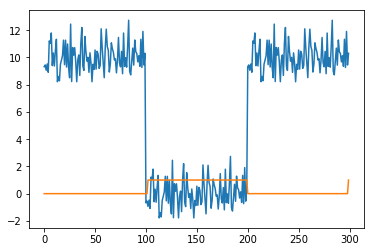

In [ ]:
Cplot(s)
Cplot(Z)

plt.show()

# Test hmm to learn to generate a a $continuous$ sequence based on a $observations$

### Test with higher noise presence

In [184]:
X = []
l = []

for i in range(0, 200):
    
    lgth = np.random.randint(20, 200)
    amp = np.random.randint(2, 30)
    noise = np.random.normal(0, 1, lgth)
    
    s0 = amp*noise*np.ones(lgth)
    s1 = noise*np.ones(lgth)
    
    s = np.r_[s0, s1]
    
    #extract features of my signal (std and mean)
    s_m = Window_mean(s, 1, window_len=round_up_to_even(lgth/20))
    s_std = Window_std(s, 1, window_len=round_up_to_even(lgth/20))
    
    X_i = [[s_i_m, s_i_std] for s_i_m, s_i_std in zip(s_m, s_std)]

    X.append(X_i)
    l.append(len(s))
    
X_train = np.concatenate(X)

#train model with binary observations
model = hmm.GaussianHMM(n_components=2).fit(X_train, l)

In [185]:
#test discovering states based on a sample observation
#generate new signal
lgth = 100

noise = np.random.normal(0, 1, lgth)

s0 = 10*noise*np.ones(lgth)
s1 = noise*np.ones(lgth)

s = np.r_[s0, s1, s0]

#extract features of my signal (std and mean)
s_m = Window_mean(s, 1, window_len=round_up_to_even(lgth/20))
s_std = Window_std(s, 1, window_len=round_up_to_even(lgth/20))

X_test = [[s_i_m, s_i_std] for s_i_m, s_i_std in zip(s_m, s_std)]

Z = model.predict(X_test)
print(Z)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 0]


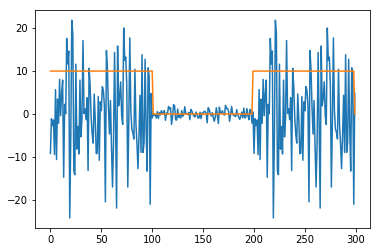

In [186]:
plt.plot(s)
plt.plot(10*Z)

plt.show()

### Test with difference in frequency

In [257]:
#generate sine wave with different frequencies
X_zcr = []
X_m = []
l = []

time = np.linspace(0, 50, 1000)

for i in range(0, 100):
    
    amp = np.random.randint(2, 30)
    freq1 = np.random.randint(2, 10)
    freq2 = np.random.randint(11, 20)
    freq3 = np.random.randint(20, 100)
    
    s0 = amp*np.sin(freq1*time)
    s1 = amp*np.sin(freq2*time)
    s2 = amp*np.sin(freq3*time)
    
    s = np.r_[s0, s1, s2]
    
    #extract features of my signal (std and mean)
#     s_m = Window_mean(s, 1, window_len=round_up_to_even(lgth/20))
    s_zcr = Window_zcr(s, 1, window_len=round_up_to_even(len(time)/20))
    
    
    X_i_zcr = [[s_i_zcr] for s_i_zcr in s_zcr]
#     X_i_m = [[s_i_m] for s_i_m in s_m]
    
    X_zcr.append(X_i_zcr)
#     X_m.append(X_i_m)
    l.append(len(s))


In [259]:
X_train_zcr = np.concatenate(X_zcr)
# X_train_m = np.concatenate(X_m)
# print(X[0:10])
# X_train = X
#train model with binary observations
model_zcr = hmm.GaussianHMM(n_components=4).fit(X_train_zcr, l)
# model_m = hmm.GaussianHMM(n_components=2).fit(X_train_m, l)

In [292]:
#test discovering states based on a sample observation
#generate new signal
time = np.linspace(0, 50, 1000)



s0 = 5*np.sin(40*time)
s1 = 5*np.sin(time)
s2 = 5*np.sin(10*time)

s = np.r_[s2, s1, s0, s1]

#extract features of my signal (std and mean)
# s_m = Window_mean(s, 1, window_len=round_up_to_even(lgth/20))
# s_std = Window_std(s, 1, window_len=round_up_to_even(lgth/20))
s_zcr = Window_zcr(s, 1, window_len=round_up_to_even(len(time)/10))
# s_m = Window_mean(s, 1, window_len=round_up_to_even(len(time)/20))

X_test_zcr = [[s_zcr_i] for s_zcr_i in s_zcr]
# X_test_mean = [[s_m_i] for s_m_i in s_m]

Z_zcr = model_zcr.predict(X_test_zcr)
# Z_m = model.predict(X_test_mean)

Z_zcr
print(Z_zcr)

[0 0 0 ... 2 2 2]


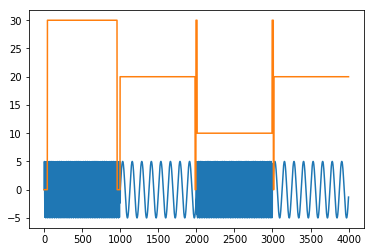

In [293]:
plt.plot(s)
plt.plot(10*Z_zcr)
# plt.plot(10*Z_m)
plt.show()